# Project

## Customer Supprt Agent
### StateManagemnt


**KEY COMPONENETS**:\n
-> **State Management**: Using TypedDict to define and manage the state of each customer interaction/ Agent\n
-> **Query Categorization **: Classify customer quries into Techinical, Billing or General categories∇
-> **Statement analysis** : Determinig the emotional tone of customer queries.
-> **Reponse Generation **: creating appropriate responses based on the query
-> **Escalatio Mechanism** : Automatically Escalating queries with negative , positive or neutral sentiment to humanagents.
->** WorkFlow Graph** : Utilizaing Langraph to create flexible and extensible workflow


** Methods *:\
**Initializa:**  Set up the enviornment and import necessary libraries.
**State Definition:** Create a structure to hold query information, category, sentiment, and response.
**Node Functions:** Implement seperate functions for categorization, senttiment analysis, and response generation.
**Graph Construction:** Use StateGraph to define the workflow, adding nodes and edges to represent the support process.
**Conditional Routing:** Implement logic to route queries based on their category and sentiment.
**Workflow Compilation:** Compile the graph into an executable application.
**Execution:**  Process customer queries through the workflow and retrieve results.


!pip install -q -U

1.   langchain_google_genai  ||
2.   langchain_groq



**Install Dependencies**
!langchain-google-genai || langchain_groq

In [24]:
!pip install -q -U langchain langgraph langchain_core  langchain_community langchain_google_genai

In [25]:
from google.colab import userdata
from langchain_google_genai import ChatGoogleGenerativeAI

# Retrieve the API key securely
api_key = userdata.get('GOOGLE_API_KEY')

# Initialize the ChatGoogleGenerativeAI object
llm = ChatGoogleGenerativeAI(
    tempreature=0,
    model="gemini-1.5-flash",
    api_key=api_key
)

llm.invoke(f"What is contactless  , give short answer")



AIMessage(content='Contactless refers to technologies that allow interaction without physical touch, typically using radio waves or other short-range wireless communication.', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-4514d386-1e66-45f8-a923-7264aec1fca3-0', usage_metadata={'input_tokens': 8, 'output_tokens': 25, 'total_tokens': 33, 'input_token_details': {'cache_read': 0}})

In [26]:
# State Management: Using TypedDict to define and manage the state of each customer/ Agent interaction.
from typing import TypedDict, Dict
from langchain.prompts import ChatPromptTemplate

class State(TypedDict):
  query: str
  category: str
  sentiment: str
  response: str

# Query Categorization *: Classify customer quries into Techinical, Billing or General categories

def categorize(state:State) -> State:
  "Technical, Billing, General"
  prompt = ChatPromptTemplate.from_template(
      "You are great assistance. Your roll is Customer Support Agent.Categorize the following  customer query into one of these catagories"
      "Technical, Billing, General. Query: {query}"
  )
  chain = prompt | llm
  category = chain.invoke({"query": state["query"]}).content
  return {"category": category}

# Escalatio Mechanism : Automatically Escalating queries with negative , positive or neutral sentiment to humanagents
def analyze_sentiment(state: State)-> State:
  prompt = ChatPromptTemplate.from_template(
      " You are great assistance. Your roll is Customer Support Agent.Analize the sentiment of customer query"
      "response with either Negative, Positive, Neutral. Query: {query}"
  )
  chain = prompt | llm
  sentiment = chain.invoke({"query": state["query"]}).content
  return {"sentiment": sentiment}

def handle_technical(state:State)-> State:
  prompt = ChatPromptTemplate.from_template(
      "provide technical support response to the following query: {query}"
  )
  chain = prompt | llm
  response = chain.invoke({"query": state["query"]}).content
  return {"response": response}

def handle_billing(state:State)-> State:
  prompt = ChatPromptTemplate.from_template(
      "provide billing support  response to the folowing query: {query}"
  )
  chain = prompt | llm
  response = chain.invoke({"query": state["query"]}).content
  return {"response": response}

def handle_general(state:State)-> State:
  prompt = ChatPromptTemplate.from_template(
      "provide general support  response to the following query: {query}"
  )
  chain = prompt | llm
  response = chain.invoke({"query": state["query"]}).content
  return {"response": response}

def escalate(state: State)-> State:
    return {"response": "This query has been escalate to human agent due to its negative sentiment"}


def route_query(state: State) -> State:
  if state["sentiment"] == "Negative":
    return "escalate"
  elif state["category"] == "Technical":
    return "handle_technical"
  elif state["category"] == "Billing":
    return "handle_billing"
  else:
    return "handle_general"


**Create a configure Graph** Create Nodes for the graph

In [27]:
from langgraph.graph import StateGraph, END
from langchain_core.runnables.graph import MermaidDrawMethod
from IPython.display import display, Image
workflow = StateGraph(State)

# start node
workflow.add_node("categorize", categorize)
workflow.add_node("analyze_sentiment", analyze_sentiment)
workflow.add_node("handle_technical", handle_technical)
workflow.add_node("handle_billing", handle_billing)
workflow.add_node("handle_general", handle_general)
workflow.add_node("escalate", escalate)

# Edges
workflow.add_edge("categorize","analyze_sentiment")
workflow.add_conditional_edges(
    "analyze_sentiment",
    route_query,{
        "handle_technical" : "handle_technical",
        "handle_billing" : "handle_billing",
        "handle_general" : "handle_general",
        "escalate" : "escalate"
    }
)

workflow.add_edge("handle_technical", END)
workflow.add_edge("handle_billing", END)
workflow.add_edge("handle_general", END)
workflow.add_edge("escalate", END)

workflow.set_entry_point("categorize")
app = workflow.compile()

**### Visulaze the complied Graph**

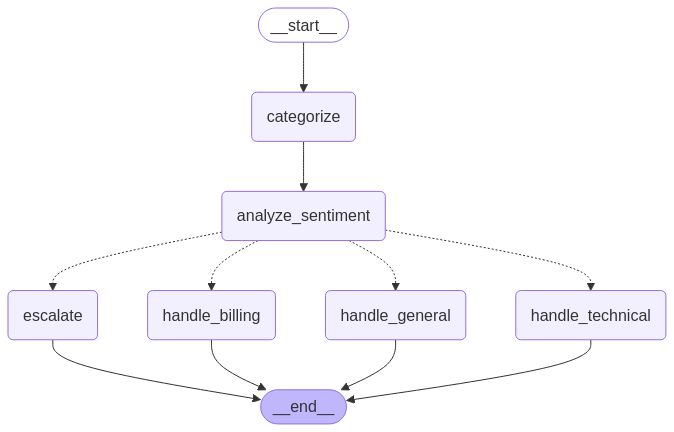

In [28]:
display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API
        )
    )
)

### **Fianly Customer Service function to take queries**

In [29]:
def run_customer_support(query:str)->Dict[str,str]:
  results = app.invoke({"query": query})
  return {
      "category":results["category"],  # Changed 'categoery' to 'category'
      "sentiment":results["sentiment"],
      "response":results["response"]
  }
# ======================
# class State(TypedDict):
#   query: str
#   category: str
#   sentiment: str
#   response: str

In [30]:
run_customer_support("My internate connection is slow. Can you help ")

{'category': 'Technical',
 'sentiment': 'Negative.  The customer is expressing a problem (slow internet connection) and requesting assistance, indicating dissatisfaction with the current service.',
 'response': 'Subject: Re: Slow Internet Connection\n\nHi [Customer Name],\n\nThanks for contacting us about your slow internet connection.  To help me troubleshoot this effectively, I need some more information. Please tell me:\n\n* **What is your internet service provider (ISP)?** (e.g., Comcast, Verizon, AT&T)\n* **What type of connection do you have?** (e.g., DSL, Cable, Fiber, Satellite)\n* **What speeds are you paying for?** (e.g., 100 Mbps, 1 Gbps)\n* **What devices are experiencing slow speeds?** (e.g., laptop, desktop, phone, smart TV)\n* **Are all devices experiencing slow speeds, or just some?**\n* **When did the slow speeds start?**  Was there a recent change (new device, software update, etc.)?\n* **Can you describe the slowness?** (e.g., pages load slowly, videos buffer constan

In [31]:
# query = "hi thanks for support. where I can find receip?   "
query = "My internate connection is slow. Can you help?   "
results = run_customer_support(query)

print(f"Query:{query}")
print(f"Category: {results['category']}")
print(f"Sentiment: {results['sentiment']}")
print(f"Response: {results['response']}")
print("\n")



Query:My internate connection is slow. Can you help?   
Category: Technical
Sentiment: Negative.  The customer is expressing a problem (slow internet) and requesting assistance, indicating dissatisfaction with the current service.
Response: Subject: Re: Slow Internet Connection

Thanks for contacting us about your slow internet connection.  To help me troubleshoot this effectively, I need some more information. Please tell me:

* **What is your internet service provider (ISP)?** (e.g., Comcast, Verizon, AT&T)
* **What type of internet connection do you have?** (e.g., DSL, Cable, Fiber, Satellite)
* **What is the speed you are paying for?** (e.g., 100 Mbps, 1 Gbps)
* **What devices are experiencing the slow connection?** (e.g., all devices, just your laptop, etc.)
* **Are all websites/applications slow, or just specific ones?** If specific, please provide examples.
* **What is the approximate speed you are currently experiencing?** (You can use a speed test website like speedtest.net or

In [32]:
query = "what is microsoft dymanic 365 functional consultant?   "
results = run_customer_support(query)

print(f"Query:{query}")
print(f"Category: {results['category']}")
print(f"Sentiment: {results['sentiment']}")
print(f"Response: {results['response']}")
print("\n")


Query:what is microsoft dymanic 365 functional consultant?   
Category: General
Sentiment: The sentiment of the query "What is a Microsoft Dynamics 365 Functional Consultant?" is **General**.  It's a straightforward informational request, not expressing positive or negative feelings.
Response: A Microsoft Dynamics 365 Functional Consultant is a business and technology professional who helps organizations implement and optimize Microsoft Dynamics 365 solutions.  They bridge the gap between business needs and the technical capabilities of the software.  Their role focuses on understanding a client's business processes, mapping those processes to Dynamics 365 functionalities, and configuring the system to meet specific requirements. This often includes things like data migration, process automation, system integration, and user training.  Essentially, they ensure the software effectively solves the client's business problems.  They are less involved in the technical coding aspects of the 

In [33]:
! pip install -q -U gradio

### Braod casting code
### run project through CLI and sent

In [34]:

import gradio as gr

def run_customer_support(query: str) -> Dict[str, str]:
    results = app.invoke({"query": query})
    return {
        "Category": results['category'],
        "Sentiment": results['sentiment'],
        "Response": results['response']
    }

# Create the Gradio interface
def gradio_interface(query: str):
    result = run_customer_support(query)
    return (
        f"**Category:** {result['Category']}\n\n"
        f"**Sentiment:** {result['Sentiment']}\n\n"
        f"**Response:** {result['Response']}"
    )

# Build the Gradio app
gui = gr.Interface(
    fn=gradio_interface,
    theme='Yntec/HaleyCH_Theme_Orange_Green',
    inputs=gr.Textbox(lines=2, placeholder="Enter your query here..."),
    outputs=gr.Markdown(),
    title="Customer Support Assistant",
    description="Provide a query and receive a categorized response. The system analyzes sentiment and routes to the appropriate support channel.",
)

# Launch the app
if __name__ == "__main__":
    gui.launch()

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://f7c9ab5920481422da.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
